# 8. Ordering based on Gradients

In [1]:
from src import *

## Description

Order the films and rests for an averaged gradients over participants to then order the films and rests videos in some manifold.

GOAL: Ordering metric and observing the relative positions of movies/rest

## Table of Contents

- [Visualization of static gradients](#all)

- [Ordering of Videos](#order)
    - Procrustes parameters induced distance 
    - Network distance ordering when compared to 1 fixed gradient (e.g Rest)
    - Ordering with Static Grads
    - Ordering with Dynamic Grads

<a class="anchor" id="all"></a>
### Visualization of Static Gradients across all movies

In [2]:
path  = './resources/static_grad/group_level/'
grads = []
labels = []
for mov in os.listdir(path):
    mname = mov.split('_')[0]
    if '414' in mov: 
        continue
    grads.append(load(path + mov))
    labels.append(mname)

In [3]:
aligned, ref, score = procrustes_align(grads, ref=None, n_iter=100)
aligned = np.asarray(aligned)

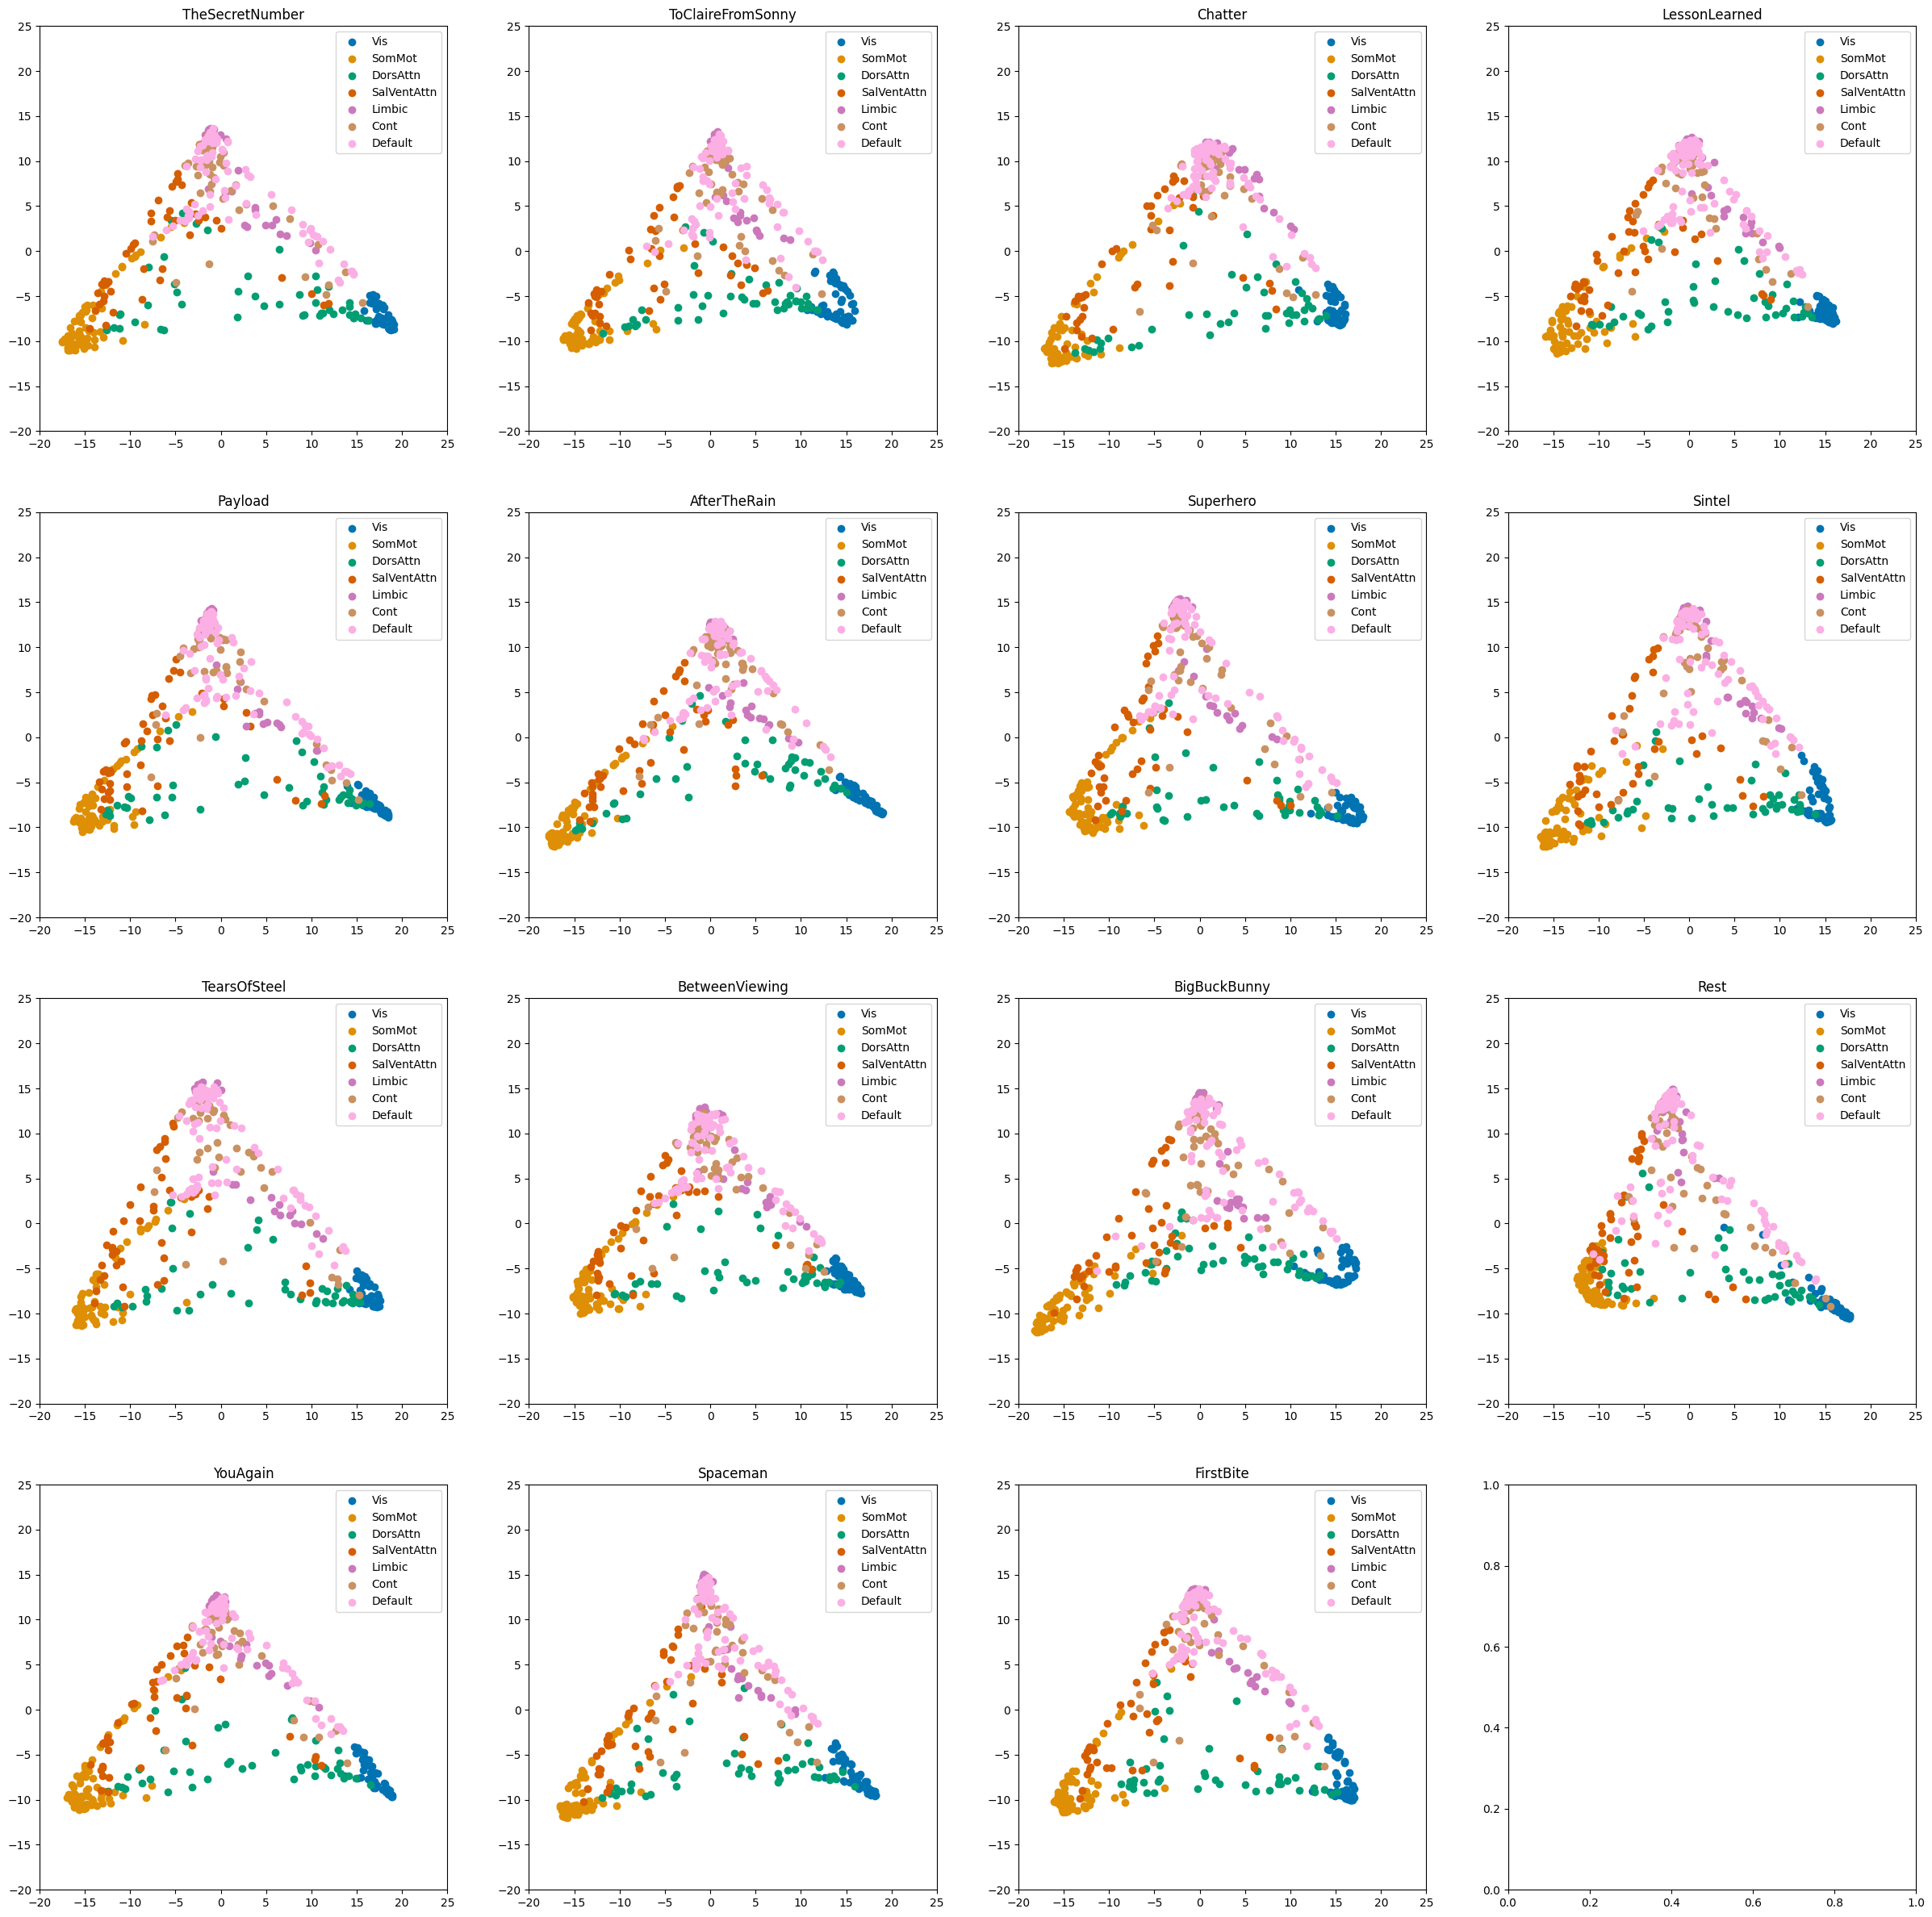

In [6]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)

colors  = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}

partial_region = load('./resources/yeo7region400.pkl')

fig, ax = plt.subplots(4,4, figsize=(30,30))
for i in range(len(labels)):
    r,c = i//4, i%4
    L = labels[i]
    G = aligned[i]

    for k in partial_region:
        
        ax[r,c].scatter(G[partial_region[k],0],G[partial_region[k],1], label=k, color=colors[k])

    ax[r,c].set_title(L)
    ax[r,c].set_xlim(-20,25)
    ax[r,c].set_ylim(-20,25)
    ax[r,c].legend()

## Ordering

### 1. Using procrustes parameters to locate each film relatively to rest

(Limitation) procrustes does not necessarily capture all dissimilarity between gradients as its parameters are only orientation related it is probably not relevant in our case.

In [7]:
# estimate here the transform (in procrustes in our case, there is only rotation and reflection involved)
def estimate_procrustes_transform(source, target):
    u, w, vt = np.linalg.svd(target.T.dot(source).T)
    t = u.dot(vt)
    return t

def get_params_transform(t):
    rot = np.arccos(t[0,0])
    if np.isnan(rot): rot = 0
    tx  = t[0,2]
    ty  = t[1,2]

    return rot,tx,ty

In [8]:
# Anchor using Rest
features = [] 
rest = grads[2]
for i in range(len(grads)):
    trsf = estimate_procrustes_transform(grads[i], rest)
    a,b,c = get_params_transform(trsf)
    features.append([a,b,c])
features = np.asarray(features)

# Anchor using Another Movie
features2 = [] 
rmovie = grads[10]
for i in range(len(grads)):
    trsf = estimate_procrustes_transform(grads[i], rmovie)
    a,b,c = get_params_transform(trsf)
    features2.append([a,b,c])
features2 = np.asarray(features2)

/tmp/ipykernel_170836/1685828528.py:8: RuntimeWarning: invalid value encountered in arccos
  rot = np.arccos(t[0,0])


[]

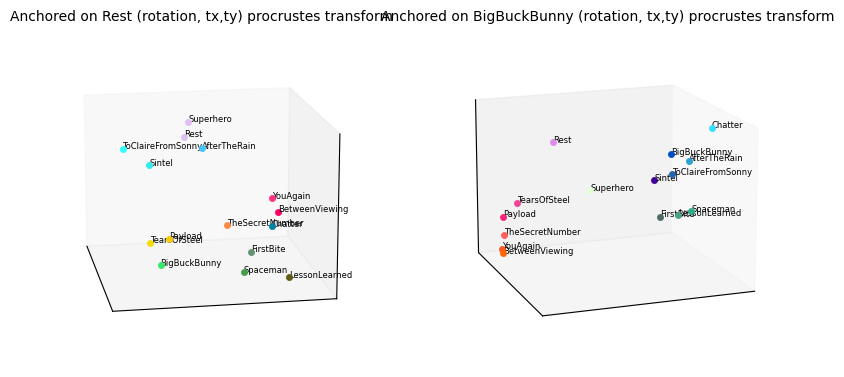

In [9]:
from mpl_toolkits import mplot3d

colormap = np.zeros_like(features)
colormap[:,0] = sscore(features[:,0])
colormap[:,1] = sscore(features[:,1])
colormap[:,2] = sscore(features[:,2])
colormap[:,0] = colormap[:,0]**(1/2)
colormap[:,1] = colormap[:,1]**(1/2)
colormap[:,2] = colormap[:,2]**(1/2)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

for idx,mov in enumerate(labels):
    ax.scatter([features[idx,0]],
            [features[idx,1]],
            [features[idx,2]], linewidth=0.5, label=mov, color=colormap[idx,:])
    ax.text(features[idx,0] , features[idx,1], features[idx,2], mov, None, size=6)
    
ax.view_init(15, 170)
ax.set_title('Anchored on Rest (rotation, tx,ty) procrustes transform', size=10)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

colormap = np.zeros_like(features)
colormap[:,0] = sscore(features2[:,0])
colormap[:,1] = sscore(features2[:,1])
colormap[:,2] = sscore(features2[:,2])
colormap[:,0] = colormap[:,0]**(1/2)
colormap[:,1] = colormap[:,1]**(1/2)
colormap[:,2] = colormap[:,2]**(1/2)

ax = fig.add_subplot(1, 2, 2, projection='3d')
for idx,mov in enumerate(labels):
    ax.scatter([features2[idx,0]],
            [features2[idx,1]],
            [features2[idx,2]], linewidth=0.5, label=mov, color=colormap[idx,:])
    ax.text(features2[idx,0] , features2[idx,1], features2[idx,2], mov, None, size=6)
ax.view_init(15, 70)
ax.set_title('Anchored on {} (rotation, tx,ty) procrustes transform'.format(labels[10]), size=10)
# ax.legend(loc=4,prop={'size':5})
# ax.legend(loc=4,prop={'size':5})
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

### 2. Using distance to gradients directly to anchor on rest and a movie

In [10]:
# grads_features = np.zeros((len(grads),len(networks)))
# for k in range(len(grads)):
#     grads_features[k] = np.asarray([network_volume(grads[k], R) for idx, R in enumerate(networks)])

In [11]:
def gradients_network_distance(G1,G2,similarity=True):
    networks = list(index2region.keys())
    if G1.shape[0] == 400:
        networks = networks[:-1] # remove sub
    V1 = np.asarray([network_volume(G1, R) for idx, R in enumerate(networks)])
    V2 = np.asarray([network_volume(G2, R) for idx, R in enumerate(networks)])
#     dist = np.sum((V1 - V2)**2)
    if similarity:
        dist = pearson_correlation(V1,V2)
    else:
        dist = np.sum((V1 - V2)**2)
    return dist

In [12]:
grads    = np.asarray(grads)
dist_mat = np.zeros((len(grads), len(grads)))
for r,g1 in enumerate(grads):
    for c,g2 in enumerate(grads):
#         dist = gradients_distance(g1,g2)
        dist = gradients_network_distance(g1,g2, similarity=False)
        dist_mat[r,c] = dist

In [14]:
np.array(labels)[np.argsort(dist_mat[:,2])]

array(['Chatter', 'YouAgain', 'AfterTheRain', 'LessonLearned',
       'BetweenViewing', 'ToClaireFromSonny', 'FirstBite', 'Sintel',
       'TheSecretNumber', 'Spaceman', 'BigBuckBunny', 'Rest', 'Payload',
       'Superhero', 'TearsOfSteel'], dtype='<U17')

### 3. Using gradients and distance matrix to compute 2d embedding for order of films

Compute similarity matrix and obtain eigenvectors

In [15]:
from numpy.linalg import eig

similar  = False
aligned  = np.asarray(aligned)
aff_mat  = np.zeros((len(aligned), len(aligned)))
for r,g1 in enumerate(aligned):
    for c,g2 in enumerate(aligned):
#         dist = gradients_distance(g1,g2)
        dist         = gradients_network_distance(g1,g2, similarity=similar)
        aff_mat[r,c] = dist


if not similar:
    aff_mat = 1 - aff_mat/(aff_mat.max())
# aff_mat = 1/ (aff_mat/(aff_mat.max()) + 1)

eigval, eigvect = eig(aff_mat)
eigvect = eigvect.real 

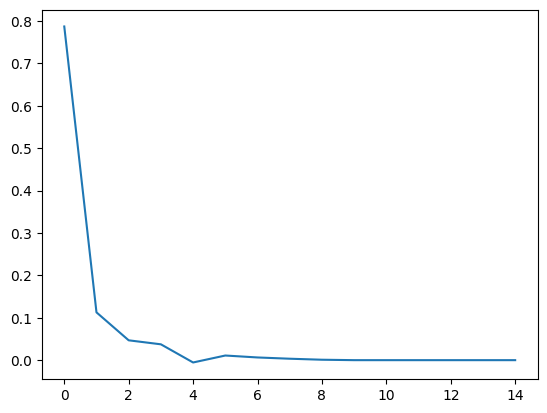

In [17]:
plt.plot(eigval/eigval.sum())

[]

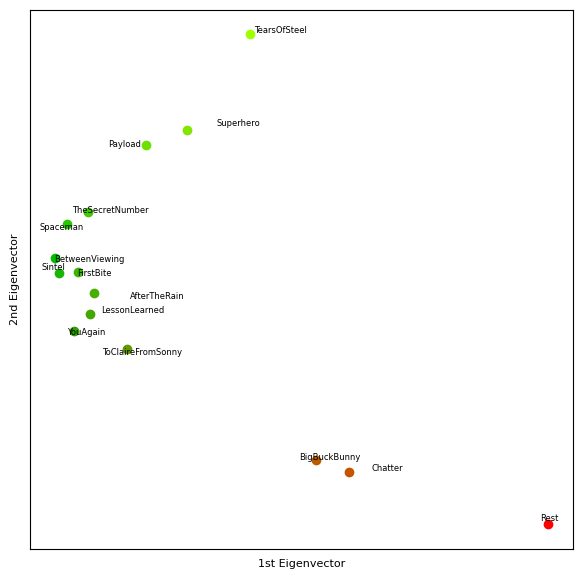

In [18]:
np.random.seed(17)
twograds = eigvect[:,[0,1]]

colormap = np.zeros_like(twograds)
colormap[:,0] = sscore(twograds[:,0])
colormap[:,1] = sscore(twograds[:,1])
colormap[:,0] = colormap[:,0]**(1/2)
colormap[:,1] = colormap[:,1]**(1/2)
colormap = np.concatenate((colormap,np.zeros((twograds.shape[0],1))),axis=1)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)


for i, txt in enumerate(labels):
    ax.scatter([twograds[i][0]], [twograds[i][1]], color=colormap[i])
    
    ax.annotate(txt, (twograds[i][0] + (np.random.random()-0.5) / 40,
                     twograds[i][1] + (np.random.random()-0.5) / 40 ) ,size=6 )

# ax.set_title("Ordering of films: static group gradient", size=11)
# ax.legend(loc=2, prop={'size':10})
ax.set_xlabel("1st Eigenvector", size=8)
ax.set_ylabel("2nd Eigenvector", size=8)
ax.set_xticks([])
ax.set_yticks([])

### 4. Ordering Dynamic Grad

Load the group level dynamic gradients 

In [38]:
path  = './resources/dynamic_grad/group_level/'
grads = []
labels = []
paths = [f for f in os.listdir(path) if '120' in f]
for mov in paths:
    grad,var = load(path + mov)
    grads.append(grad)
    labels.append(mov.split('_')[0])
grads = np.asarray(grads)

/tmp/ipykernel_151701/2072436759.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grads = np.asarray(grads)


Sample from the dynamic gradients group level since there is no point in selecting gradients that are too similar to each other (with only 1 frame difference)

In [73]:
track = []
total_grad  = []
samplesize  = 20
markerlabel = []
for k in range(len(grads)):

    cur_grad    = grads[k][:,:,:3]
    save_grad   = cur_grad[np.arange(0,cur_grad.shape[0], samplesize)]
    markerlabel += [(k,j) for j in np.arange(0,cur_grad.shape[0], samplesize)]
    track.append([labels[k]] * save_grad.shape[0])
    total_grad.append(save_grad)

track         = np.concatenate(track)
total_grad    = np.concatenate(total_grad)
aligned,ref,s = procrustes_align(total_grad)

Compute similarity matrix and obtain eigenvectors

In [75]:
from numpy.linalg import eig

similar  = False
aligned  = np.asarray(aligned)
aff_mat  = np.zeros((len(aligned), len(aligned)))
for r,g1 in enumerate(tqdm(aligned)):
    for c,g2 in enumerate(aligned):
#         dist = gradients_distance(g1,g2)
        dist         = gradients_network_distance(g1,g2, similarity=similar)
        aff_mat[r,c] = dist


if not similar:
    aff_mat     = 1 - aff_mat/(aff_mat.max())
# aff_mat         = 1/ (aff_mat/(aff_mat.max()) + 1)
eigval, eigvect = eig(aff_mat)

eigvect = eigvect.real

  0%|          | 0/339 [00:00<?, ?it/s]

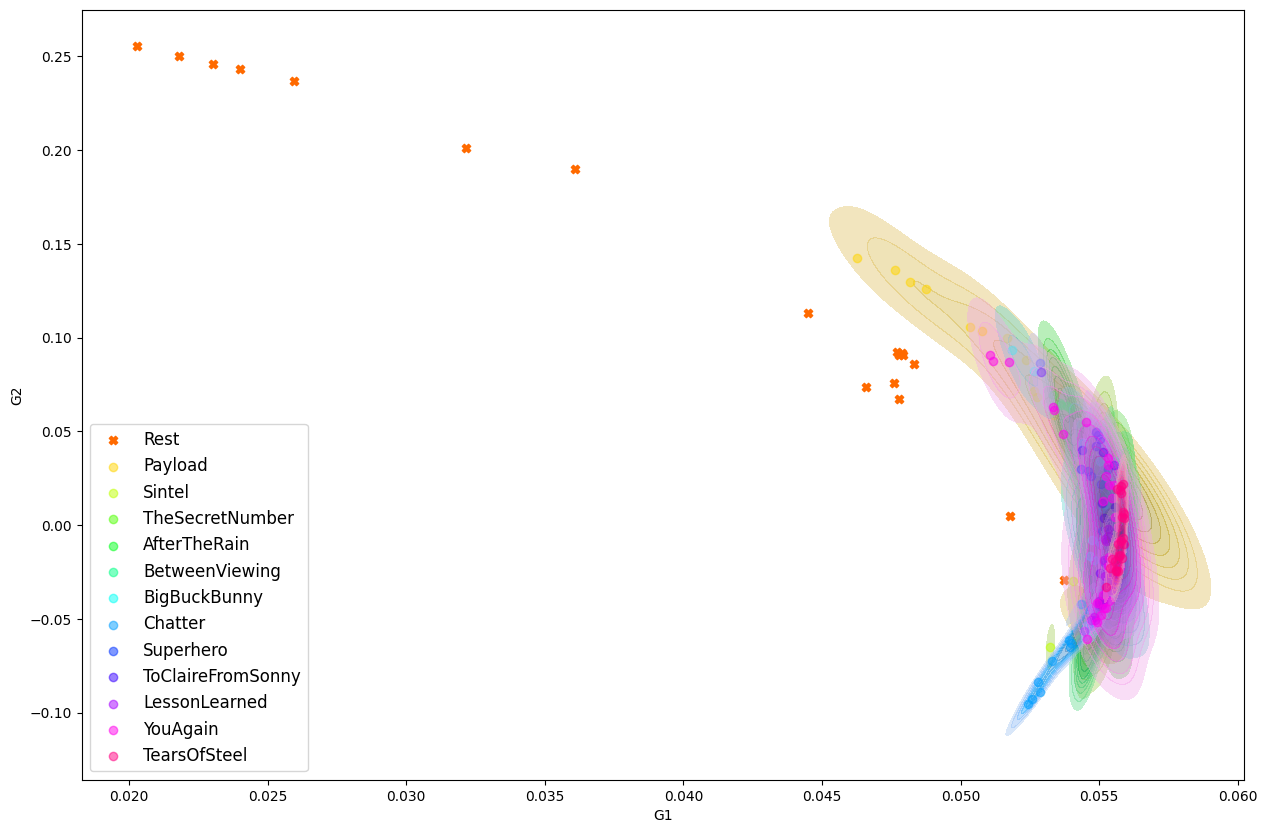

In [78]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('hsv', len(set(track)))
my_cmap = ListedColormap(pal)

fig , ax = plt.subplots(figsize=(15,10))
for i,m in enumerate(set(track)):
    if m == 'Rest':
#         df = {'G1': eigvect[track==m, 0], 'G2': eigvect[track==m,1]}
#         sns.kdeplot(data=df, x="G1", y="G2", fill=True, 
#                     color= my_cmap.colors[i], alpha=0.4, 
#                     thresh=0.1, ax=ax)        
        ax.scatter(eigvect[track==m, 0],eigvect[track==m,1], label=m, color = my_cmap.colors[i], marker='X')
    else:
        df = {'G1': eigvect[track==m, 0], 'G2': eigvect[track==m,1]}
        sns.kdeplot(data=df, x="G1", y="G2", fill=True, 
                    color= my_cmap.colors[i], alpha=0.4, 
                    thresh=0.1, ax=ax)
        ax.scatter(eigvect[track==m, 0],eigvect[track==m,1], label=m, color = my_cmap.colors[i], alpha=0.5)
    
ax.legend(prop={'size':12})
# ax.set_title("Distances between movies'dynamic gradients")

Text(0.5, 0, 'G2')

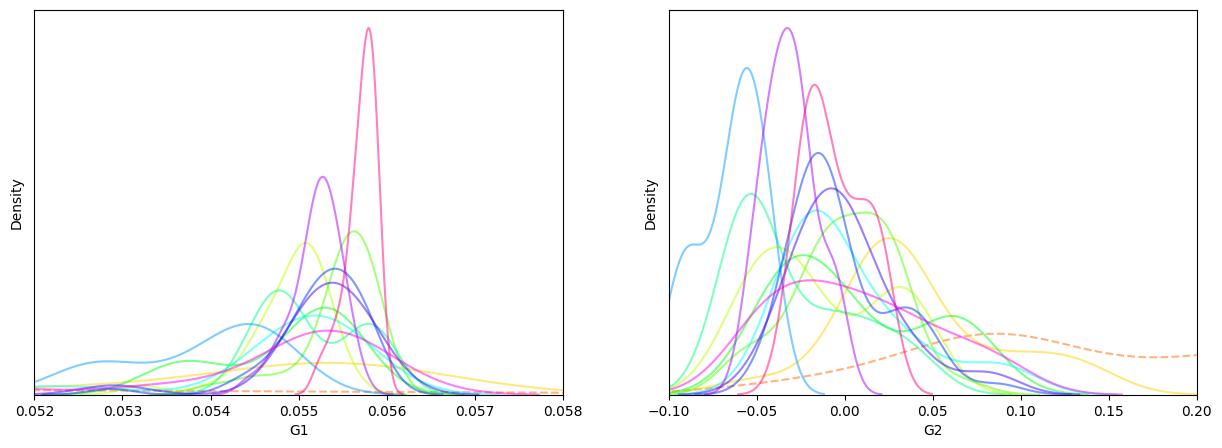

In [67]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for i,m in enumerate(set(track)):
    if m =='Rest':
        sns.kdeplot(eigvect[track==m, 0], color = my_cmap.colors[i], label=m, alpha=0.5, ax=ax[0], linestyle='--')
    else:
        sns.kdeplot(eigvect[track==m, 0], color = my_cmap.colors[i], label=m, alpha=0.5, ax=ax[0])

# ax[0].legend()
ax[0].set_yticks([])
ax[0].set_xlim(0.052,0.058)
ax[0].set_xlabel('G1')

for i,m in enumerate(set(track)):
    if m =='Rest':
        sns.kdeplot(eigvect[track==m, 1], color = my_cmap.colors[i], label=m, alpha=0.5, ax=ax[1], linestyle='--')
    else:
        sns.kdeplot(eigvect[track==m, 1], color = my_cmap.colors[i], label=m, alpha=0.5, ax=ax[1])

# ax[1].legend()
ax[1].set_xlim(-0.1,0.2)
ax[1].set_yticks([])
ax[1].set_xlabel('G2')
# plt.xlim(0,0.1)